# Extreme humid heat across Southeast Europe
Author: Oriana Chegwidden, CarbonPlan

Prepared with funding by the The World Bank / Global Facility for Disaster Reduction and Recovery (GFDRR)

Exposure to extreme heat is increasing in cities across the world. Heat stress is associated
with a range of negative outcomes, increasing health risks, crime, violence, heightened levels of
energy consumption, and reduced economic productivity and educational attainment. These
negative outcomes place a disproportionate burden on already excluded groups of urban
residents, such as low-income people, older residents, and those with chronic illnesses or
disabilities. For these reasons, in the interests of urban livability, economic productivity,
inclusion, and sustainability, it is essential for cities to take action to mitigate and adapt to
excessive urban heat. Despite the growing impacts of heatwaves on vulnerable populations,
they remain a ‘hidden hazard’ that is insufficiently recognized or addressed. The World Bank’s
Global Practice for Urban, Resilience and Land (GPURL) and Global Facility for Disaster
Reduction and Recovery have developed a program of analytical work and technical advisory
services to city and national counterparts to support the strengthening of preparedness and
mitigation actions for extreme heat.

This notebook analyzes data located in public cloud storage. The data can be either downloaded and worked with on your own computer in a program like Excel or with python using this notebook. Alternatively, given an internet connection and this notebook, you can read the data directly and analyze it remotely.

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import warnings
import xarray as xr
from utils import map_cities, multipanel_map, calc_emergence_categories, emergence_cmap, plot_multipanel_daily_timeseries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy
import matplotlib
import numpy as np
import matplotlib as mpl
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rc("font", family="sans-serif")
matplotlib.rc("font", serif="Helvetica Neue")
matplotlib.rc("text", usetex="false")
matplotlib.rcParams.update({"font.size": 14, "svg.fonttype": "none"})

Select the different options that you might be interested in

In [3]:
# variable determines whether you are interested in WBGT in the sun or in the shade. Options: 'WBGT-shade', 'WBGT-sun'
variable = 'WBGT-sun'
# time_frame is the center year of a 20 year period of interest. As in, 2070 would provide results representative of the period 2060-2079. 
# 'historical' denotes the period 1985-2014. Options: 'historical', '2030', '2050', '2070'
time_frame = '2070'
# scenario is the emissions pathway you are interested in. Options: ssp245, ssp370
scenario = 'ssp370'
# The exceedance threshold you're interested in (degrees C). Options: 25, 27, 29, 30, 30.5, 32, 35
threshold = 29

Load in file looking at days exceeding the selected threshold.

In [4]:
df = pd.read_csv("s3://carbonplan-climate-impacts/extreme-heat-extension/v1.0/outputs/csv/"+\
                 f"carbonplan-extreme-heat-days-over-{threshold}-degC-{variable}.csv")

Inspect the file's contents. You'll see multiple columns describing the city name, its corresponding ID, as well as the results for different scenarios and time frames.

Load in csv file showing annual maximum WBGT in the shade

In [5]:
df = pd.read_csv("s3://carbonplan-climate-impacts/extreme-heat-extension/v1.0/"+\
                 f"outputs/csv/carbonplan-extreme-heat-annual-maximum-{variable}.csv")

Rank the cities from hottest to coolest for the scenario and time frame you're interested in.

In [6]:
df.sort_values(f'annual maximum - CarbonPlan - {scenario}-{time_frame}', 
               ascending=False).head(10)

ID_HDC_G0      UC_NM_MN  longitude   latitude  \
114     4237.0         Adana  35.283133  37.003430   
128     5513.0      Sumgayit  49.655708  40.570583   
129     5528.0          Baku  49.872645  40.420291   
116     4339.0       Antakya  36.160915  36.220686   
121     4531.0     Şanlıurfa  38.806255  37.155155   
69      3377.0       Larissa  22.419055  39.627161   
74      3416.0      Chalkida  23.607194  38.468867   
71      3384.0  Thessaloniki  22.937061  40.642086   
118     4424.0     Gaziantep  37.382735  37.050169   
123     4666.0        Batman  41.133137  37.889571   

     annual maximum - CarbonPlan - historical  \
114                                 34.273299   
128                                 32.736339   
129                                 32.878726   
116                                 33.112043   
121                                 33.339148   
69                                  32.792032   
74                                  32.739822   
71                                  32.947595   
118                                 32.870796   
123                                 32.931839   

     annual maximum - CarbonPlan - ssp245-2030  \
114                                  35.420299   
128                                  34.273831   
129                                  34.293028   
116                                  34.360131   
121                                  34.403502   
69                                   33.808001   
74                                   34.008530   
71                                   34.159449   
118                                  33.858716   
123                                  33.919053   

     annual maximum - CarbonPlan - ssp245-2050  \
114                                  35.948018   
128                                  34.785928   
129                                  34.857436   
116                                  34.852060   
121                                  34.930582   
69                                   34.524792   
74                                   34.636912   
71                                   34.712137   
118                                  34.580820   
123                                  34.617233   

     annual maximum - CarbonPlan - ssp245-2070  \
114                                  36.608200   
128                                  35.403861   
129                                  35.496193   
116                                  35.454192   
121                                  35.304003   
69                                   34.701532   
74                                   34.929671   
71                                   35.106651   
118                                  35.024331   
123                                  34.913284   

     annual maximum - CarbonPlan - ssp370-2030  \
114                                  35.407630   
128                                  34.304352   
129                                  34.239307   
116                                  34.330829   
121                                  34.430722   
69                                   34.134231   
74                                   34.143412   
71                                   34.080769   
118                                  33.977246   
123                                  33.990758   

     annual maximum - CarbonPlan - ssp370-2050  \
114                                  36.315260   
128                                  35.088781   
129                                  34.952761   
116                                  35.042675   
121                                  35.099569   
69                                   34.595954   
74                                   34.675782   
71                                   34.816377   
118                                  34.661292   
123                                  34.775470   

     annual maximum - CarbonPlan - ssp370-2070  
114                                  37.037572  
128              

Let's return to the metric of days exceeding certain thresholds and inspect the rankings there. 

In [7]:
threshold = 27 # degrees C
df = pd.read_csv("s3://carbonplan-climate-impacts/extreme-heat-extension/v1.0/outputs/csv/"+\
                 f"carbonplan-extreme-heat-days-over-{threshold}-degC-WBGT-shade.csv")

We can then rank the cities according to their number of days over the threshold for the selected scenario and timeframe.

In [8]:
df.sort_values(f'days over {threshold} degC - CarbonPlan - {scenario}-{time_frame}', 
               ascending=False).head(10)

ID_HDC_G0    UC_NM_MN  longitude   latitude  \
114     4237.0       Adana  35.283133  37.003430   
116     4339.0     Antakya  36.160915  36.220686   
121     4531.0   Şanlıurfa  38.806255  37.155155   
123     4666.0      Batman  41.133137  37.889571   
109     4139.0     Larnaca  33.615989  34.930605   
107     4094.0     Nicosia  33.346657  35.160952   
122     4599.0  Diyarbakir  40.199212  37.931481   
97      3729.0     Antalya  30.725107  36.917371   
118     4424.0   Gaziantep  37.382735  37.050169   
110     4182.0      Mersin  34.614844  36.801379   

     days over 27 degC - CarbonPlan - historical  \
114                                        68.75   
116                                        39.00   
121                                        55.00   
123                                        49.75   
109                                        39.00   
107                                        40.50   
122                                        35.50   
97                                         27.25   
118                                        31.50   
110                                        14.00   

     days over 27 degC - CarbonPlan - ssp245-2030  \
114                                         90.50   
116                                         69.25   
121                                         79.25   
123                                         73.50   
109                                         65.75   
107                                         67.00   
122                                         61.25   
97                                          55.50   
118                                         52.75   
110                                         41.50   

     days over 27 degC - CarbonPlan - ssp245-2050  \
114                                        100.75   
116                                         85.25   
121                                         90.50   
123                                         85.75   
109                                         82.75   
107                                         80.50   
122                                         73.75   
97                                          70.25   
118                                         65.25   
110                                         57.75   

     days over 27 degC - CarbonPlan - ssp245-2070  \
114                                        108.75   
116                                         95.00   
121                                         99.50   
123                                         93.00   
109                                         87.00   
107                                         85.25   
122                                         83.75   
97                                          78.50   
118                                         77.25   
110                                         70.50   

     days over 27 degC - CarbonPlan - ssp370-2030  \
114                                         90.25   
116                                         69.25   
121                                         78.75   
123                                         74.25   
109                                         65.25   
107                                         66.00   
122                                         60.00   
97                                          53.50   
118                                         53.00   
110                                         40.00   

     days over 27 degC - CarbonPlan - ssp370-2050  \
114                                        104.25   
116                                         87.50   
121                                         94.00   
123                                         90.75   
109                                         83.25   
107                                         81.25   
122                                         79.50   
97                                          71.25   
118                                         70

This shows us how different metrics can help us target different vulnerabilities. For example, some cities appear on both top 10 lists, like Adana which is the top hottest city both in annual maximum and in number of days over threshold. However, while Batman doesn't show up in the top 10 for annual maximum, it is ranked #4 on the days exceeding 27.

There's a unique risk for places that didn't typically have hot days in the past but in the future will experience them typically. In other words, historically there were, in the median, zero hot days but in the future there will be hot days. Let's see what those "emergent hot cities" are. For this example we'll switch to a higher heat threshold of 30.5 •C.

In [9]:
threshold = 30.5 # degrees C
df = pd.read_csv("s3://carbonplan-climate-impacts/extreme-heat-extension/v1.0/outputs/csv/"+\
                 f"carbonplan-extreme-heat-days-over-{threshold}-degC-WBGT-shade.csv")
historically_safe = df['days over 30.5 degC - CarbonPlan - historical']==0
future_hot = df['days over 30.5 degC - CarbonPlan - ssp370-2070']>0

There are 45 cities that in the historical typically experienced zero days over 30.5, but in the future will typically exceed that heat threshold. The top 10 cities with the highest heat burden in the future are highlighted below.

In [10]:
df[historically_safe&future_hot].sort_values('days over 30.5 degC - CarbonPlan - ssp370-2070', ascending=False).head(10)

ID_HDC_G0    UC_NM_MN  longitude   latitude  \
121     4531.0   Şanlıurfa  38.806255  37.155155   
123     4666.0      Batman  41.133137  37.889571   
116     4339.0     Antakya  36.160915  36.220686   
107     4094.0     Nicosia  33.346657  35.160952   
128     5513.0    Sumgayit  49.655708  40.570583   
109     4139.0     Larnaca  33.615989  34.930605   
129     5528.0        Baku  49.872645  40.420291   
118     4424.0   Gaziantep  37.382735  37.050169   
97      3729.0     Antalya  30.725107  36.917371   
122     4599.0  Diyarbakir  40.199212  37.931481   

     days over 30.5 degC - CarbonPlan - historical  \
121                                            0.0   
123                                            0.0   
116                                            0.0   
107                                            0.0   
128                                            0.0   
109                                            0.0   
129                                            0.0   
118                                            0.0   
97                                             0.0   
122                                            0.0   

     days over 30.5 degC - CarbonPlan - ssp245-2030  \
121                                            4.75   
123                                            0.75   
116                                            3.00   
107                                            2.00   
128                                            3.50   
109                                            1.50   
129                                            3.75   
118                                            1.50   
97                                             0.75   
122                                            0.00   

     days over 30.5 degC - CarbonPlan - ssp245-2050  \
121                                           11.50   
123                                            3.75   
116                                            6.50   
107                                            6.75   
128                                            8.50   
109                                            4.25   
129                                            8.00   
118                                            5.00   
97                                             3.00   
122                                            1.00   

     days over 30.5 degC - CarbonPlan - ssp245-2070  \
121                                           20.75   
123                                            9.25   
116                                           12.00   
107                                           11.50   
128                                           11.50   
109                                            8.25   
129                                           11.00   
118                                            9.00   
97                                             6.50   
122                                            3.00   

     days over 30.5 degC - CarbonPlan - ssp370-2030  \
121                                            5.75   
123                                            0.50   
116                                            3.25   
107                                            3.00   
128                                            4.00   
109                                            2.00   
129                                            3.75   
118                                            2.00   
97                                             1.00   
122                                            0.00   

     days over 30.5 degC - CarbonPlan - ssp370-2050  \
121                                           14.00   
123                                            5.50   
116                                            8.50   
107                                            8.00   
128                                            8.75   
109                                            7.00   
129                         

Map hot days as determined by multiple thresholds (e.g. 27 •C, 29 •C) for the studied time frames and scenarios.

In [11]:
var_limits_dict = {'WBGT-shade': {27: (0, 40),
             29: (0, 20),
             30.5: (0,5),
             32: (0,5)},
                   'WBGT-sun': {27: (0, 150),
             29: (0, 50),
             30.5: (0,50),
             32: (0,50)},
                  }

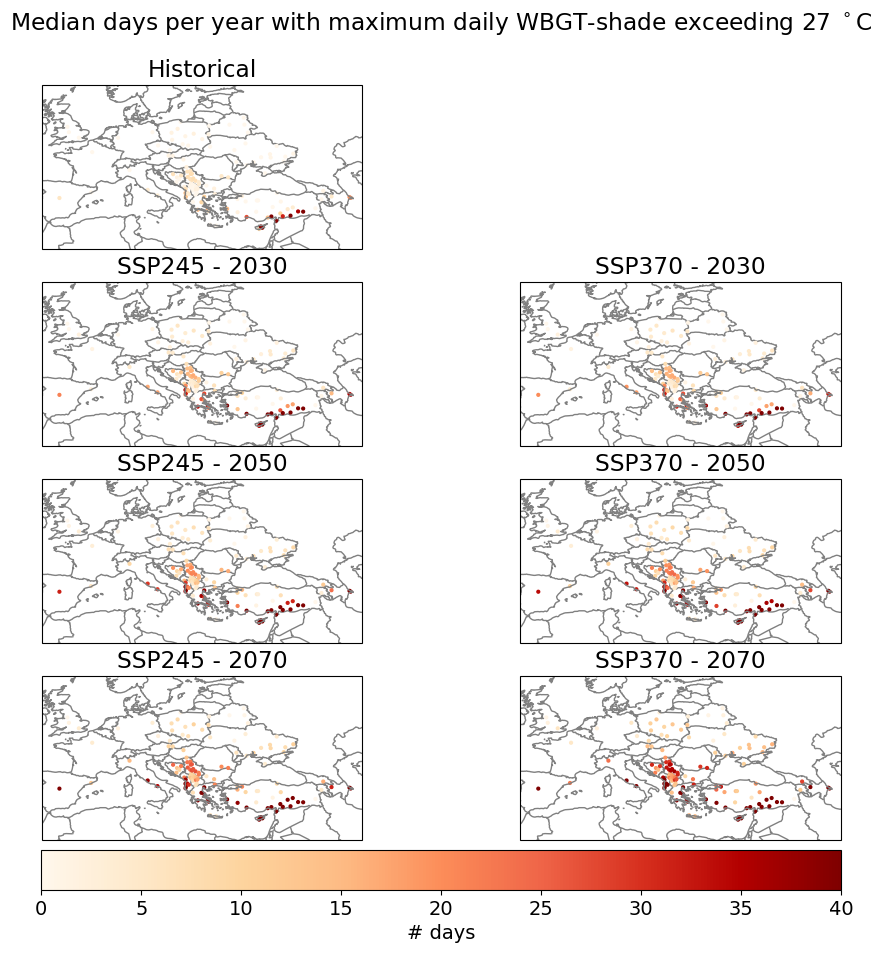

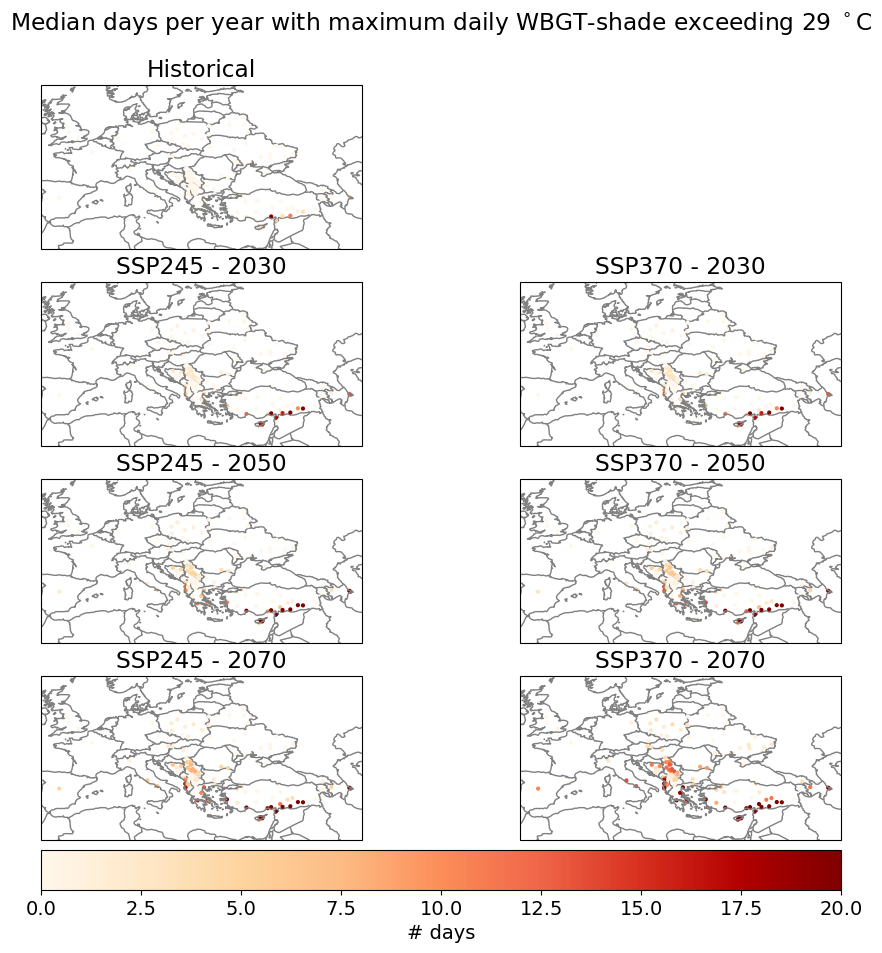

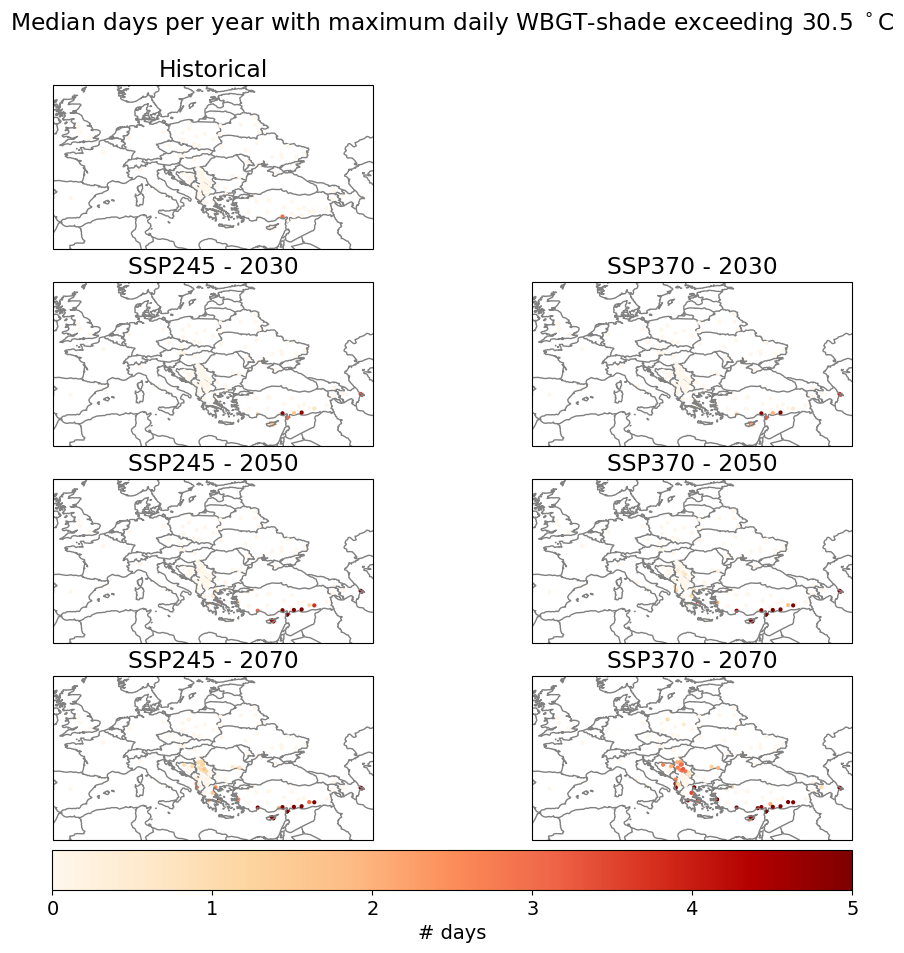

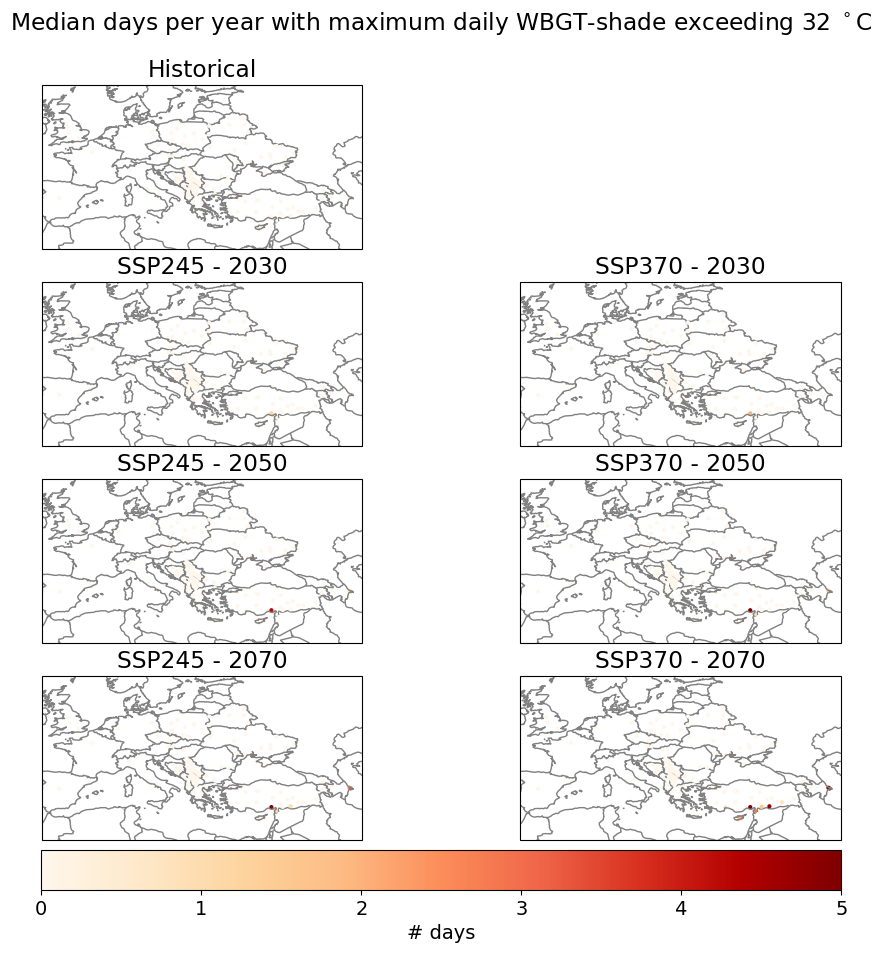

In [12]:
variable='WBGT-shade'
for threshold in [27, 29, 30.5, 32]:
    df = pd.read_csv("s3://carbonplan-climate-impacts/extreme-heat-extension/v1.0/outputs/csv/"+\
                 f"carbonplan-extreme-heat-days-over-{threshold}-degC-{variable}.csv")
    
    multipanel_map(df, threshold, var_limits_dict[variable][threshold], variable)

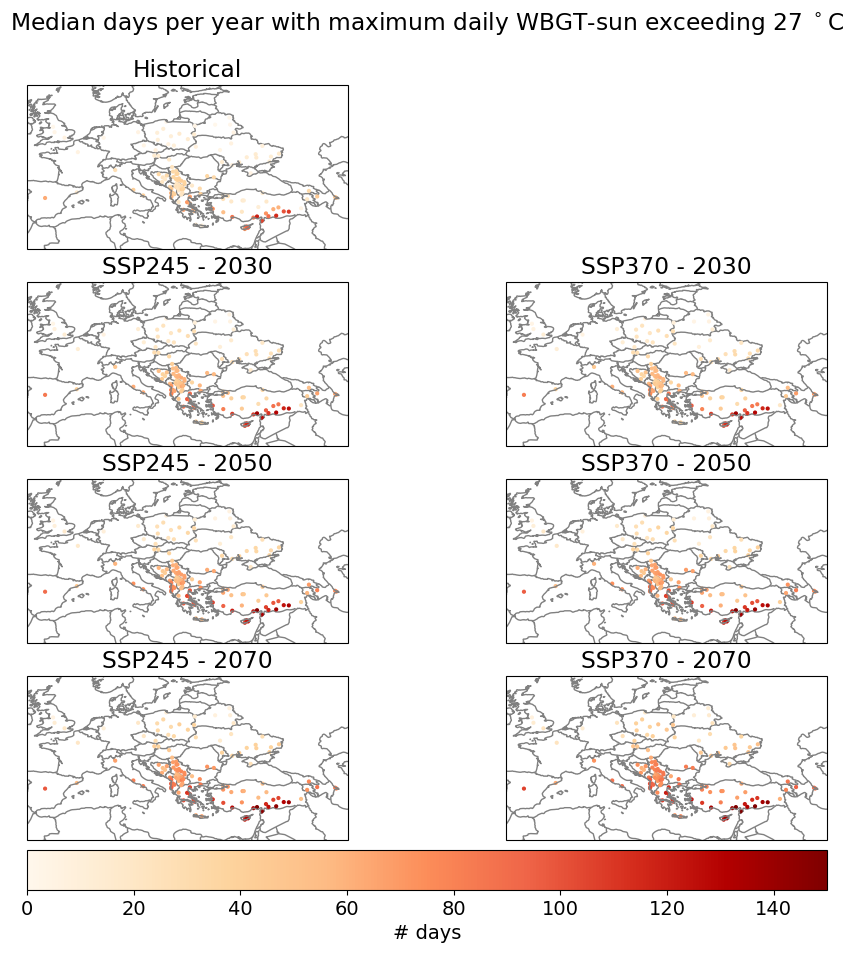

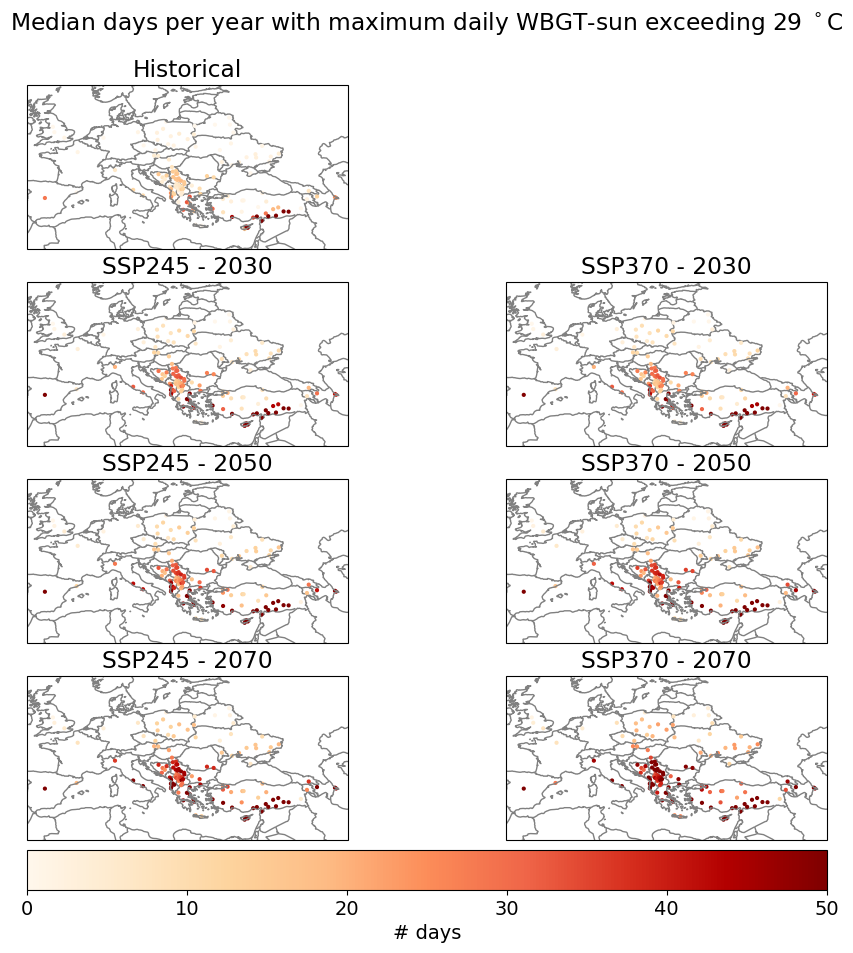

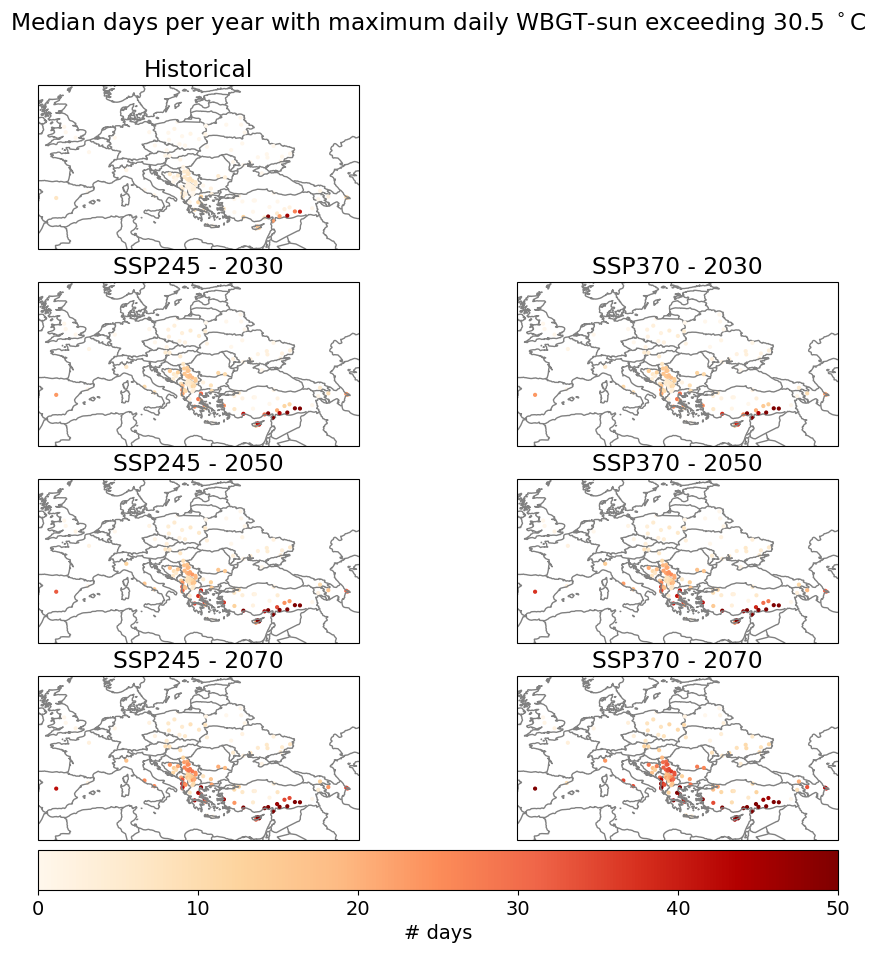

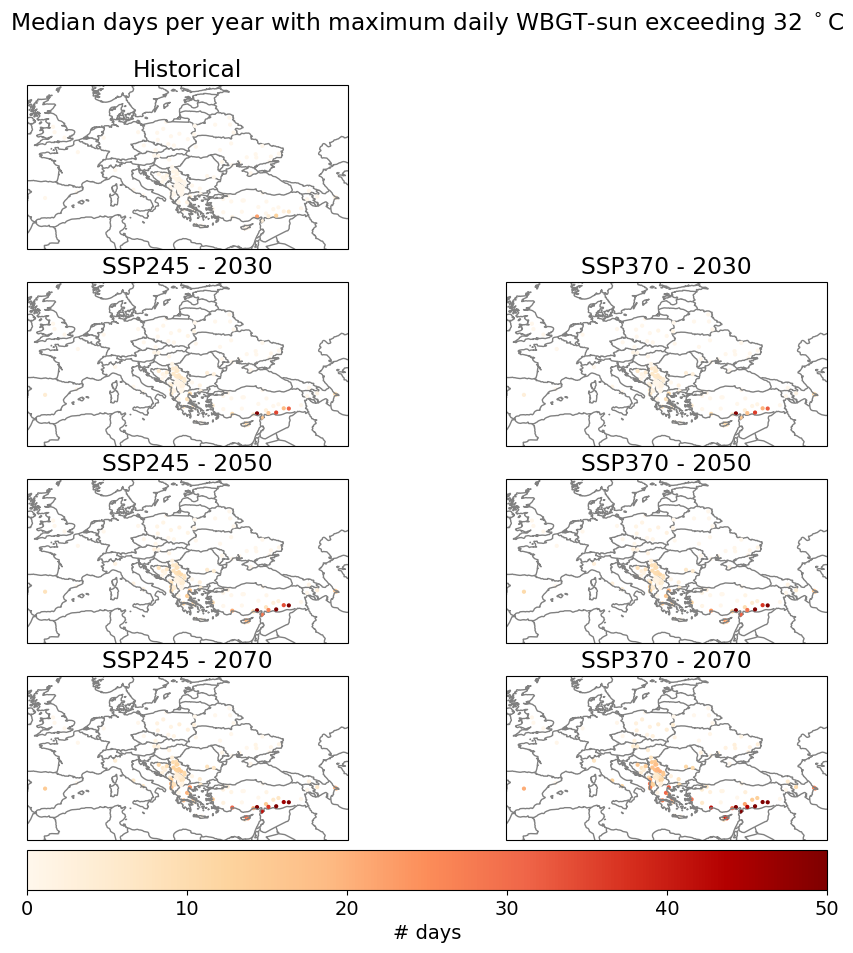

In [13]:
variable = 'WBGT-sun'
for threshold in [27, 29, 30.5, 32]:

    df = pd.read_csv("s3://carbonplan-climate-impacts/extreme-heat-extension/v1.0/outputs/csv/"+\
                 f"carbonplan-extreme-heat-days-over-{threshold}-degC-{variable}.csv")
    
    multipanel_map(df, threshold, var_limits_dict[variable][threshold], variable)

Determine time of emergence of extreme heat. Calculate _when_ each city will experience a given number of "hot" days, as defined by exceeding a threshold of interest. Some cities already experience the set number of days over threshold (and are plotted in black). Others will begin to experience that frequency of hot days in mid-century. Some, denoted in gray, did not exhibit that frequency of heat in the simulations.

In [14]:
threshold=29
df = pd.read_csv("s3://carbonplan-climate-impacts/extreme-heat-extension/v1.0/outputs/csv/"+\
                 f"carbonplan-extreme-heat-days-over-{threshold}-degC-{variable}.csv")

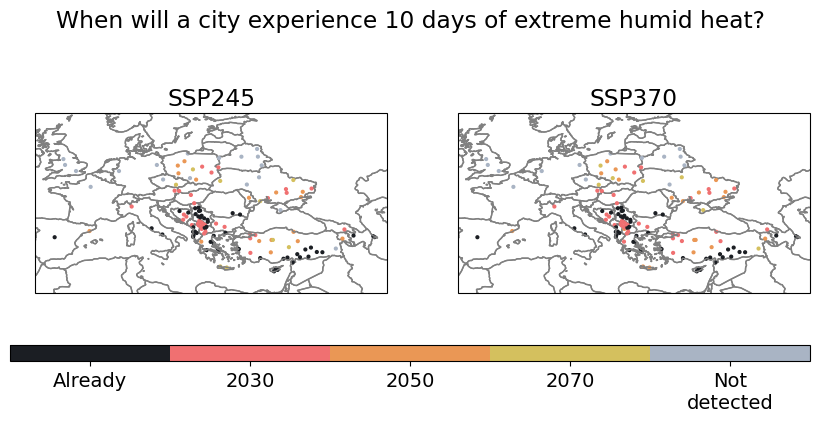

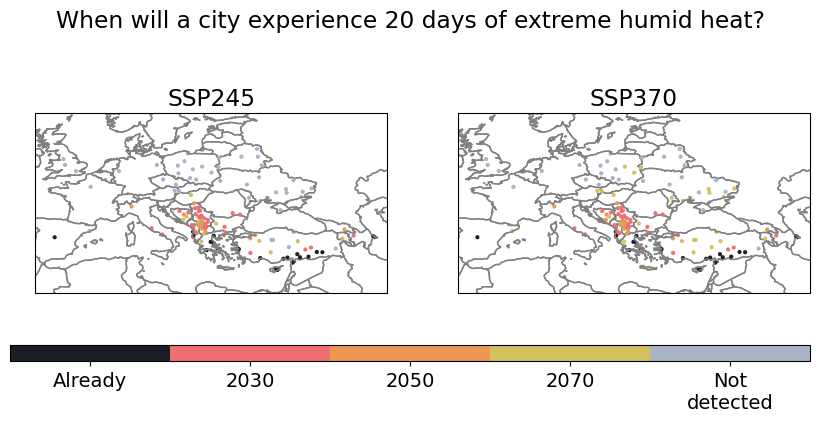

In [15]:
df = calc_emergence_categories(df)
for ndays in [10, 20]:
    fig, axarr = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, ncols=2, figsize=(10,4))
    for i, scenario in enumerate(['ssp245', 'ssp370']):                     
        axarr[i].coastlines(color='gray', zorder=-5)
        axarr[i].add_feature(cartopy.feature.BORDERS, edgecolor='gray', zorder=-5)
        axarr[i].set_extent([-7, 52, 31, 58])
        c = map_cities(axarr[i], df, f'emergence-{scenario}-{ndays}', emergence_cmap(), (0,5))
        axarr[i].set_title(scenario.upper())
    cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.04])
    fig.suptitle(f'When will a city experience {ndays} days of extreme humid heat?')
    cbar = fig.colorbar(c, cax=cbar_ax, ticks=[0.5, 1.5, 2.5, 3.5, 4.5], orientation='horizontal')
    cbar.ax.set_xticklabels(['Already', '2030', '2050', '2070', 'Not\ndetected'])
    plt.savefig(f'./figures/emergence-{ndays}-days.svg', format="svg")

Calculate the fraction of the summer tourism season to experience extreme heat.

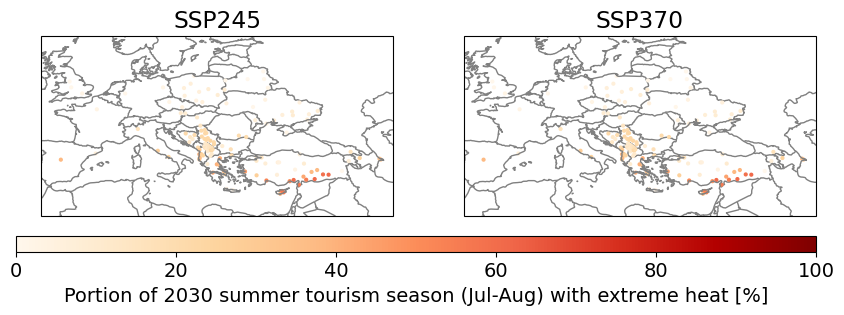

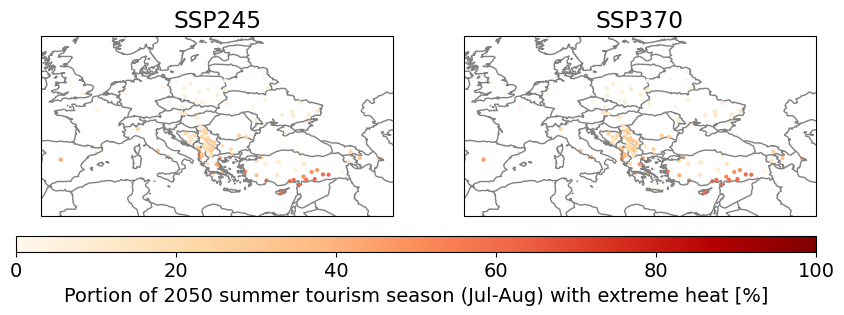

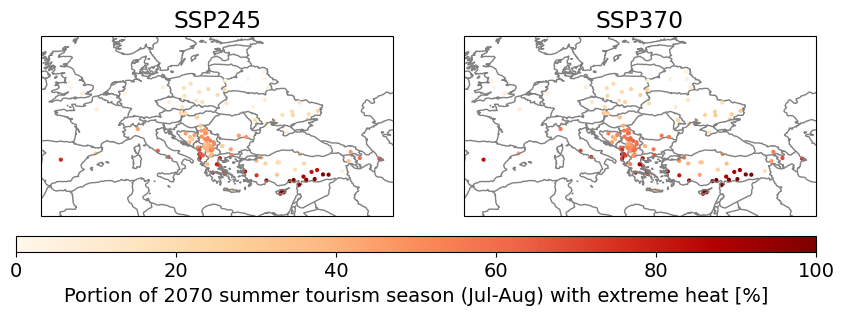

In [16]:
variable='WBGT-sun'
df = pd.read_csv("s3://carbonplan-climate-impacts/extreme-heat-extension/v1.0/outputs/csv/"+\
                 f"carbonplan-extreme-heat-holiday-days-over-{threshold}-degC-{variable}.csv")
# Calculate portion of holiday by dividing by 62 total days in July-August.
df[f'holiday days over 29 degC - CarbonPlan - ssp370-{time_frame}']/= (62*0.01)
df[f'holiday days over 29 degC - CarbonPlan - ssp245-{time_frame}']/= (62*0.01)
for time_frame in ['2030', '2050', '2070']:
    fig, axarr = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, ncols=2, figsize=(10,4))
    for i, scenario in enumerate(['ssp245', 'ssp370']):
        c = map_cities(axarr[i], df, f'holiday days over 29 degC - CarbonPlan - {scenario}-{time_frame}', 'OrRd', (0,100))
        axarr[i].set_title(scenario.upper())
    plt.subplots_adjust(bottom=0.05)
    cbar_ax = fig.add_axes([0.1, 0.15, 0.8, 0.04])
    cbar = fig.colorbar(c, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(f'Portion of {time_frame} summer tourism season (Jul-Aug) with extreme heat [%]')
    plt.savefig(f'./figures/portion-summer-season-{time_frame}.svg', format='svg')

Every city experiences a different seasonality of heat, with WBGT fluctuating and peaking at different times of year. See below for average daily WBGT timeseries for a sample set of eight different cities, each compared against a 29 degree threshold of interest. We'll first plot the historical timeseries.

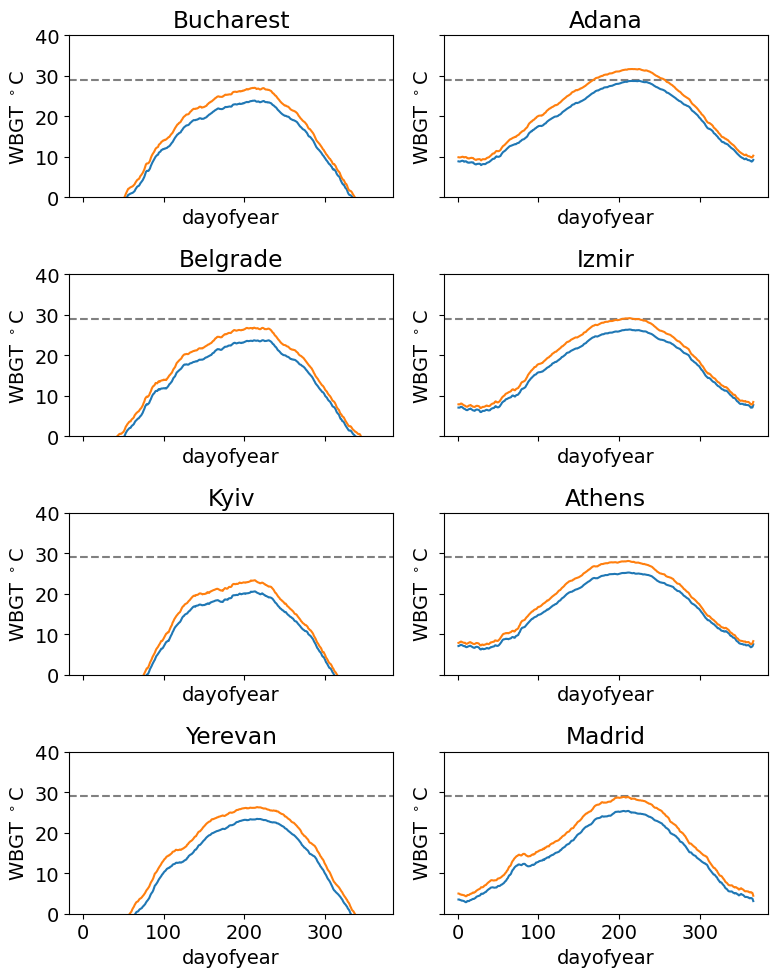

In [17]:
threshold=29

ds_shade = xr.open_zarr('s3://carbonplan-climate-impacts/extreme-heat-extension/v1.0/outputs/zarr/'+\
                         f'daily/historical-WBGT-shade.zarr/')
ds_sun = xr.open_zarr('s3://carbonplan-climate-impacts/extreme-heat-extension/v1.0/outputs/zarr/'+\
                         f'daily/historical-WBGT-sun.zarr/')
cities = ['Bucharest','Adana', 'Belgrade', 
          'Izmir', 'Kyiv',  'Athens', 'Yerevan', 'Madrid']

plot_multipanel_daily_timeseries(cities, 
                                     df, 
                                     ds_shade.sel(scenario=scenario), 
                                     ds_sun.sel(scenario=scenario),
                                    threshold,
                                        'historical',
                                'historical')

Then we can repeat the analysis but for future time periods and alternate emissions scenarios.

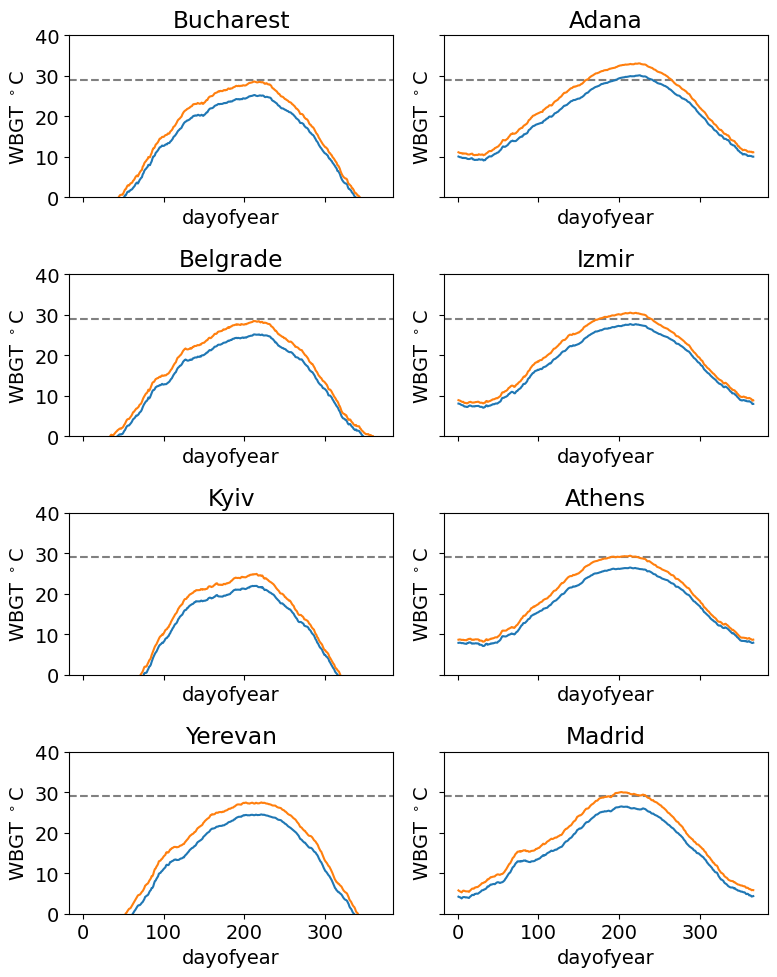

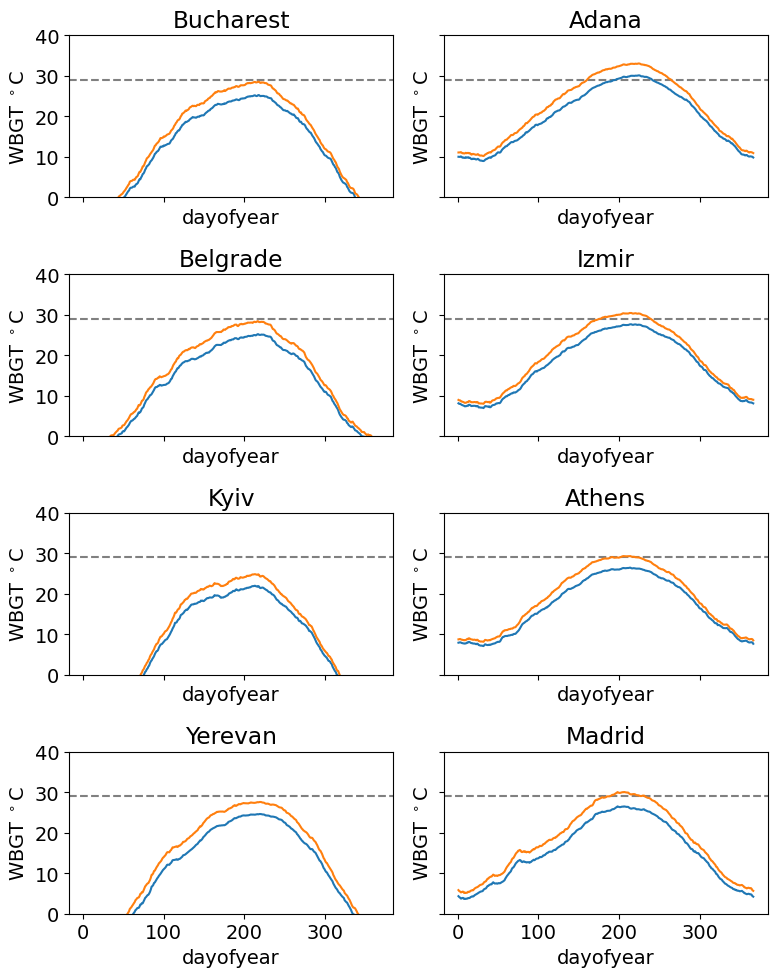

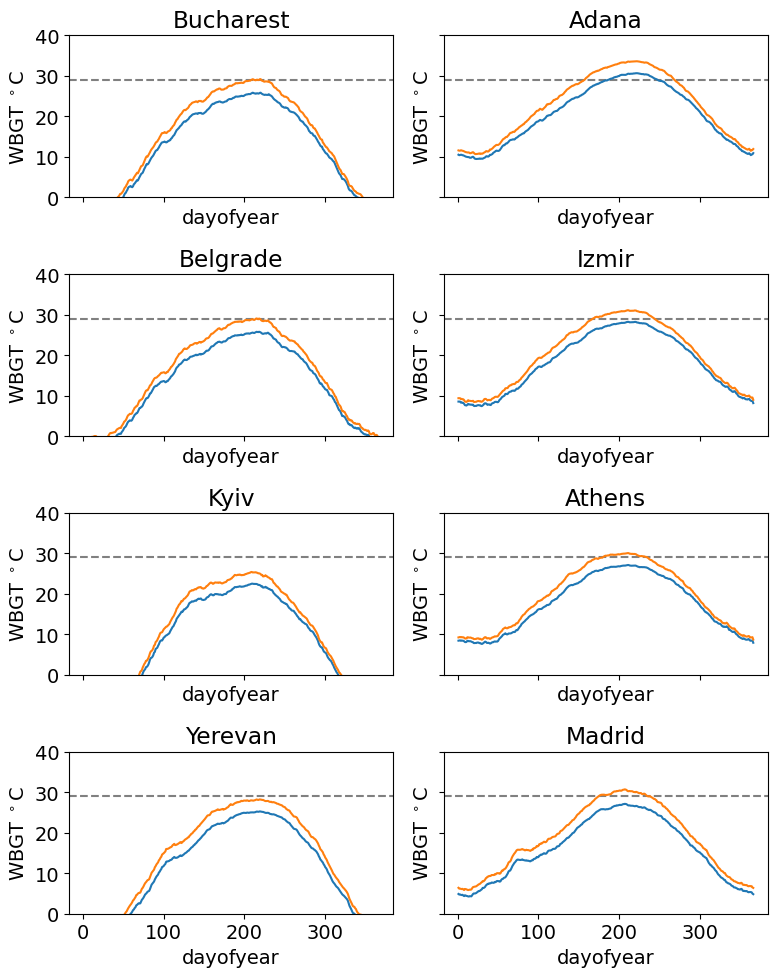

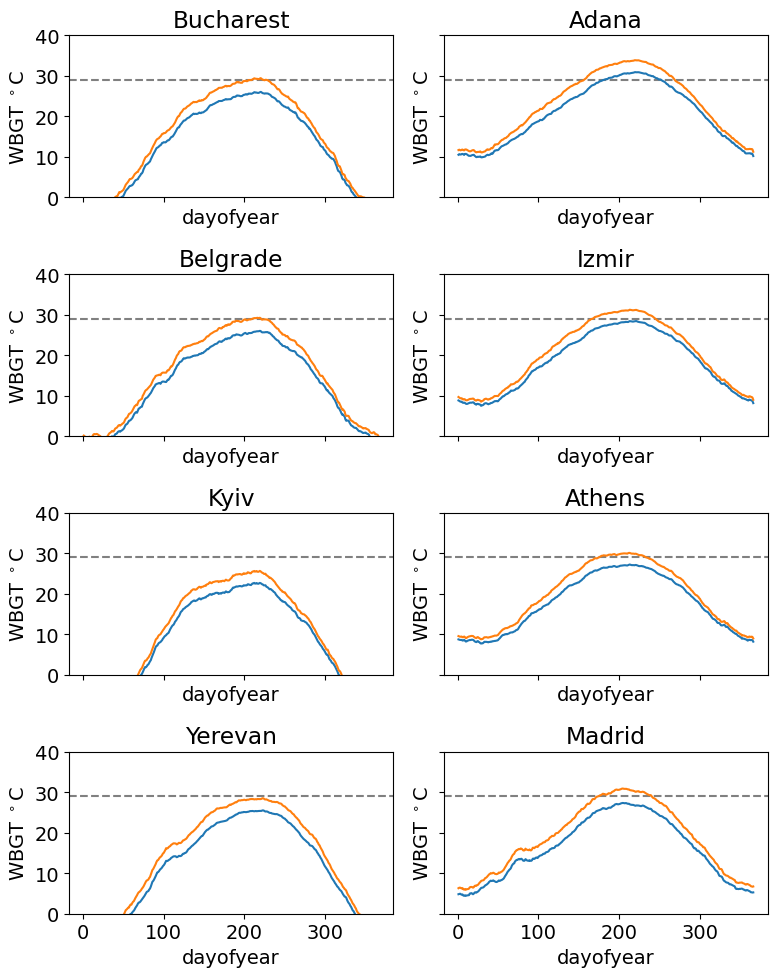

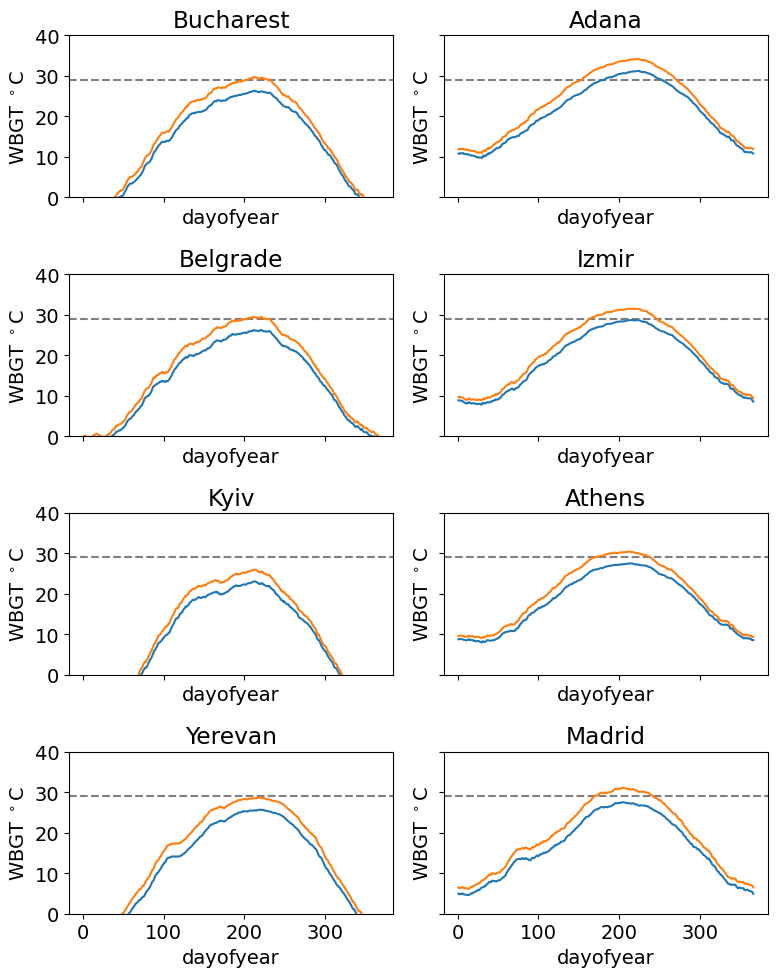

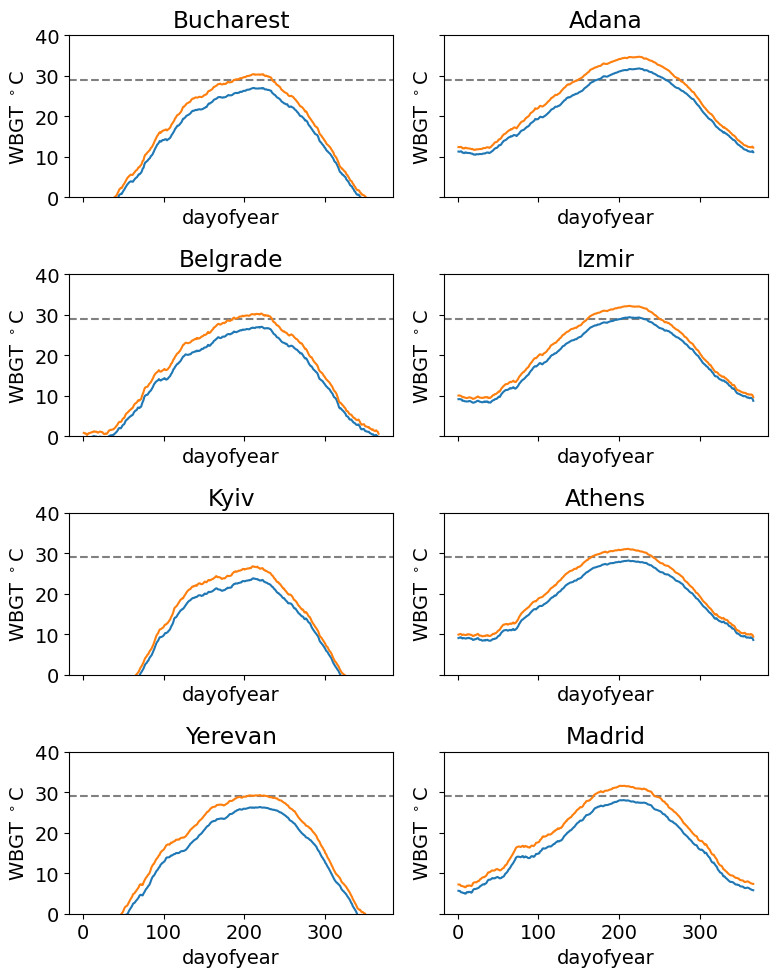

In [18]:
threshold=29

cities = ['Bucharest','Adana', 'Belgrade', 
          'Izmir', 'Kyiv',  'Athens', 'Yerevan', 'Madrid']
for time_frame in ['2030', '2050', '2070']:
    for scenario in ['ssp245','ssp370']:
        ds_shade = xr.open_zarr('s3://carbonplan-climate-impacts/extreme-heat-extension/v1.0/outputs/zarr/'+\
                         f'daily/{scenario}-{time_frame}-WBGT-shade.zarr/')
        ds_sun = xr.open_zarr('s3://carbonplan-climate-impacts/extreme-heat-extension/v1.0/outputs/zarr/'+\
                         f'daily/{scenario}-{time_frame}-WBGT-sun.zarr/')
        plot_multipanel_daily_timeseries(cities, 
                                     df, 
                                     ds_shade.sel(scenario=scenario), 
                                     ds_sun.sel(scenario=scenario),
                                    threshold,
                                         scenario,
                                        time_frame)